In [14]:
import pandas as pd
import numpy as np
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import spearmanr
from tqdm.notebook import tqdm

from config import MODEL_PATH, FEATURE_COLUMNS_PATH, HISTORICAL_DATA_PATH
from feature_engineering import create_features

In [15]:
print("--- Chargement des artefacts du modèle ---")

MODEL_PATH = '../models/f1_lgbm_model.joblib'
FEATURE_COLUMNS_PATH = '../models/feature_columns.json'

try:
    # Charger le modèle entraîné
    model = joblib.load(MODEL_PATH)
    print(f"✅ Modèle chargé depuis : {MODEL_PATH}")

    # Charger la liste des colonnes de features utilisées pour l'entraînement
    with open(FEATURE_COLUMNS_PATH, 'r') as f:
        training_features = json.load(f)
    print(f"Colonnes de features chargées depuis : {FEATURE_COLUMNS_PATH}")
    print(f"Le modèle a été entraîné avec {len(training_features)} features.")

except FileNotFoundError as e:
    print(f"ERREUR : Un fichier est introuvable. {e}")    

--- Chargement des artefacts du modèle ---
✅ Modèle chargé depuis : ../models/f1_lgbm_model.joblib
Colonnes de features chargées depuis : ../models/feature_columns.json
Le modèle a été entraîné avec 92 features.


c:\HES-SO\MA-WEM\Projet\.venv\lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\HES-SO\MA-WEM\Projet\.venv\lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [16]:
print("\n--- Chargement et séparation des données ---")

try:
    # Charger l'intégralité du dataset
    full_df = pd.read_csv("../data/F1_ALL_DATA_2020_2025.csv")
    print(f"Données complètes chargées ({len(full_df)} lignes).")

    # 1. Données historiques pour le calcul des features (contexte)
    historical_df = full_df[full_df['year'] <= 2024].copy()
    print(f"Données historiques (2020-2024) : {len(historical_df)} lignes.")

    # 2. Données de test à évaluer (cible)
    test_df_2025 = full_df[full_df['year'] == 2025].copy()

    if test_df_2025.empty:
        print("ATTENTION : Aucune donnée pour l'année 2025 n'a été trouvée dans le fichier CSV.")
    else:
        print(f"Données de test (2025) : {len(test_df_2025)} lignes.")

except FileNotFoundError:
    print(f"ERREUR: Le fichier de données 'F1_ALL_DATA_2020_2025.csv' est introuvable.")
except Exception as e:
    print(f"Une erreur est survenue: {e}")


--- Chargement et séparation des données ---
Données complètes chargées (2275 lignes).
Données historiques (2020-2024) : 2096 lignes.
Données de test (2025) : 179 lignes.


In [17]:
print("\n--- Vérification et génération de la colonne 'round' ---")

if 'round' not in full_df.columns:
    print("La colonne 'round' est manquante. Génération en cours...")
    
    full_df['race_id'] = pd.to_numeric(full_df['race_id'], errors='coerce')
    full_df.dropna(subset=['race_id'], inplace=True)
    full_df['race_id'] = full_df['race_id'].astype(int)
    
    rounds_map = full_df[['year', 'race_id']].drop_duplicates().sort_values(by=['year', 'race_id'])
    rounds_map['round'] = rounds_map.groupby('year').cumcount() + 1
    
    # Fusionner pour ajouter la colonne 'round' au DataFrame principal
    full_df = pd.merge(full_df, rounds_map, on=['year', 'race_id'], how='left')
    
    print("Colonne 'round' générée et ajoutée avec succès.")
else:
    print("La colonne 'round' est déjà présente.")


--- Vérification et génération de la colonne 'round' ---
La colonne 'round' est manquante. Génération en cours...
Colonne 'round' générée et ajoutée avec succès.


In [18]:
print("\n--- Séparation des données historiques et de test ---")

# 1. Données historiques pour le calcul des features (contexte)
historical_df = full_df[full_df['year'] <= 2024].copy()
print(f"Données historiques (2020-2024) : {len(historical_df)} lignes.")

# 2. Données de test à évaluer (cible)
test_df_2025 = full_df[full_df['year'] == 2025].copy()

if test_df_2025.empty:
    print("ATTENTION : Aucune donnée pour l'année 2025 n'a été trouvée.")
else:
    print(f"Données de test (2025) : {len(test_df_2025)} lignes.")


--- Séparation des données historiques et de test ---
Données historiques (2020-2024) : 2096 lignes.
Données de test (2025) : 179 lignes.


In [19]:
print("\n--- Lancement des prédictions pour la saison 2025 (course par course) ---")

all_results = []

if not test_df_2025.empty:
    races_to_predict = test_df_2025['race_name'].unique()
    print(f"Trouvé {len(races_to_predict)} courses à prédire pour 2025.")

    for race_name in races_to_predict:
        print(f"  -> Prédiction pour : {race_name}...")
        
        race_weekend_data = test_df_2025[test_df_2025['race_name'] == race_name].copy()
        
        # L'historique d'abord, les données à traiter ensuite
        features_df = create_features(historical_df, race_weekend_data)

        X_encoded = pd.get_dummies(features_df, columns=['team', 'race_name'], dummy_na=False)
        X_aligned = X_encoded.reindex(columns=training_features, fill_value=0)
        X_aligned = X_aligned.astype(float)

        predictions = model.predict(X_aligned)
        
        race_results = race_weekend_data[['race_name', 'driver_code', 'position']].copy()
        race_results['predicted_position'] = np.round(predictions)
        all_results.append(race_results)

    results_df = pd.concat(all_results)
    
    print("\nPrédictions terminées pour toutes les courses de 2025.")
    print("\n--- Aperçu des résultats combinés ---")
    display(results_df.head())
else:
    print("Processus de prédiction sauté car il n'y a pas de données pour 2025.")


--- Lancement des prédictions pour la saison 2025 (course par course) ---
Trouvé 9 courses à prédire pour 2025.
  -> Prédiction pour : FORMULA 1 LOUIS VUITTON AUSTRALIAN...
  -> Prédiction pour : FORMULA 1 HEINEKEN CHINESE...
  -> Prédiction pour : FORMULA 1 LENOVO JAPANESE...


c:\HES-SO\MA-WEM\Projet\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\HES-SO\MA-WEM\Projet\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  -> Prédiction pour : FORMULA 1 GULF AIR BAHRAIN...
  -> Prédiction pour : FORMULA 1 STC SAUDI ARABIAN...
  -> Prédiction pour : COM MIAMI...
  -> Prédiction pour : EMILIA-ROMAGNA...


c:\HES-SO\MA-WEM\Projet\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\HES-SO\MA-WEM\Projet\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\HES-SO\MA-WEM\Projet\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\HES-SO\MA-WEM\Projet\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  -> Prédiction pour : FORMULA 1 TAG HEUER GRAND PRIX DE MONACO...
  -> Prédiction pour : FORMULA 1 ARAMCO GRAN PREMIO DE ESPAÑA...

Prédictions terminées pour toutes les courses de 2025.

--- Aperçu des résultats combinés ---


c:\HES-SO\MA-WEM\Projet\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\HES-SO\MA-WEM\Projet\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\HES-SO\MA-WEM\Projet\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,race_name,driver_code,position,predicted_position
2096,FORMULA 1 LOUIS VUITTON AUSTRALIAN,NOR,1,1.0
2097,FORMULA 1 LOUIS VUITTON AUSTRALIAN,VER,2,3.0
2098,FORMULA 1 LOUIS VUITTON AUSTRALIAN,RUS,3,4.0
2099,FORMULA 1 LOUIS VUITTON AUSTRALIAN,ANT,4,7.0
2100,FORMULA 1 LOUIS VUITTON AUSTRALIAN,ALB,5,7.0


In [20]:
print("\n--- Évaluation des Performances ---")

if 'results_df' in locals() and not results_df.empty:
    print("Nettoyage des positions non-numériques (ex: 'NC')...")
    
    # Étape 1: Convertir la colonne 'position' en numérique. Les valeurs non valides deviendront NaN.
    results_df['position'] = pd.to_numeric(results_df['position'], errors='coerce')
    
    # Étape 2: Conserver une copie des résultats avec NaN pour une analyse future si besoin
    original_results_count = len(results_df)
    
    # Étape 3: Supprimer les lignes où la position réelle est NaN pour le calcul des métriques
    results_df.dropna(subset=['position'], inplace=True)
    
    print(f"Calcul des métriques sur {len(results_df)} sur {original_results_count} résultats classifiés.")

    # Étape 4: S'assurer que les colonnes sont bien de type numérique (float ou int)
    results_df['position'] = results_df['position'].astype(float)
    results_df['predicted_position'] = results_df['predicted_position'].astype(float)

    # --- Calcul des métriques (sur les données nettoyées) ---
    mae = mean_absolute_error(results_df['position'], results_df['predicted_position'])
    rmse = np.sqrt(mean_squared_error(results_df['position'], results_df['predicted_position']))
    r2 = r2_score(results_df['position'], results_df['predicted_position'])
    spearman_corr, _ = spearmanr(results_df['position'], results_df['predicted_position'])

    print("\n--- Métriques Globales sur la saison 2025 (résultats classifiés) ---")
    print(f"🏎️ Erreur Absolue Moyenne (MAE) : {mae:.3f} positions")
    print(f"🏁 Root Mean Squared Error (RMSE) : {rmse:.3f} positions")
    print(f"📊 Coefficient de détermination (R²) : {r2:.3f}")
    print(f"📈 Corrélation de rang de Spearman : {spearman_corr:.3f}")

    correct_predictions = (results_df['position'] == results_df['predicted_position']).sum()
    total_predictions = len(results_df)
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"🎯 Précision (prediction exacte) : {accuracy:.2f}%")
else:
    print("Etape d'évaluation sautée.")


--- Évaluation des Performances ---
Nettoyage des positions non-numériques (ex: 'NC')...
Calcul des métriques sur 155 sur 179 résultats classifiés.

--- Métriques Globales sur la saison 2025 (résultats classifiés) ---
🏎️ Erreur Absolue Moyenne (MAE) : 1.503 positions
🏁 Root Mean Squared Error (RMSE) : 2.335 positions
📊 Coefficient de détermination (R²) : 0.790
📈 Corrélation de rang de Spearman : 0.894
🎯 Précision (prediction exacte) : 32.90%



--- Visualisation des Résultats ---


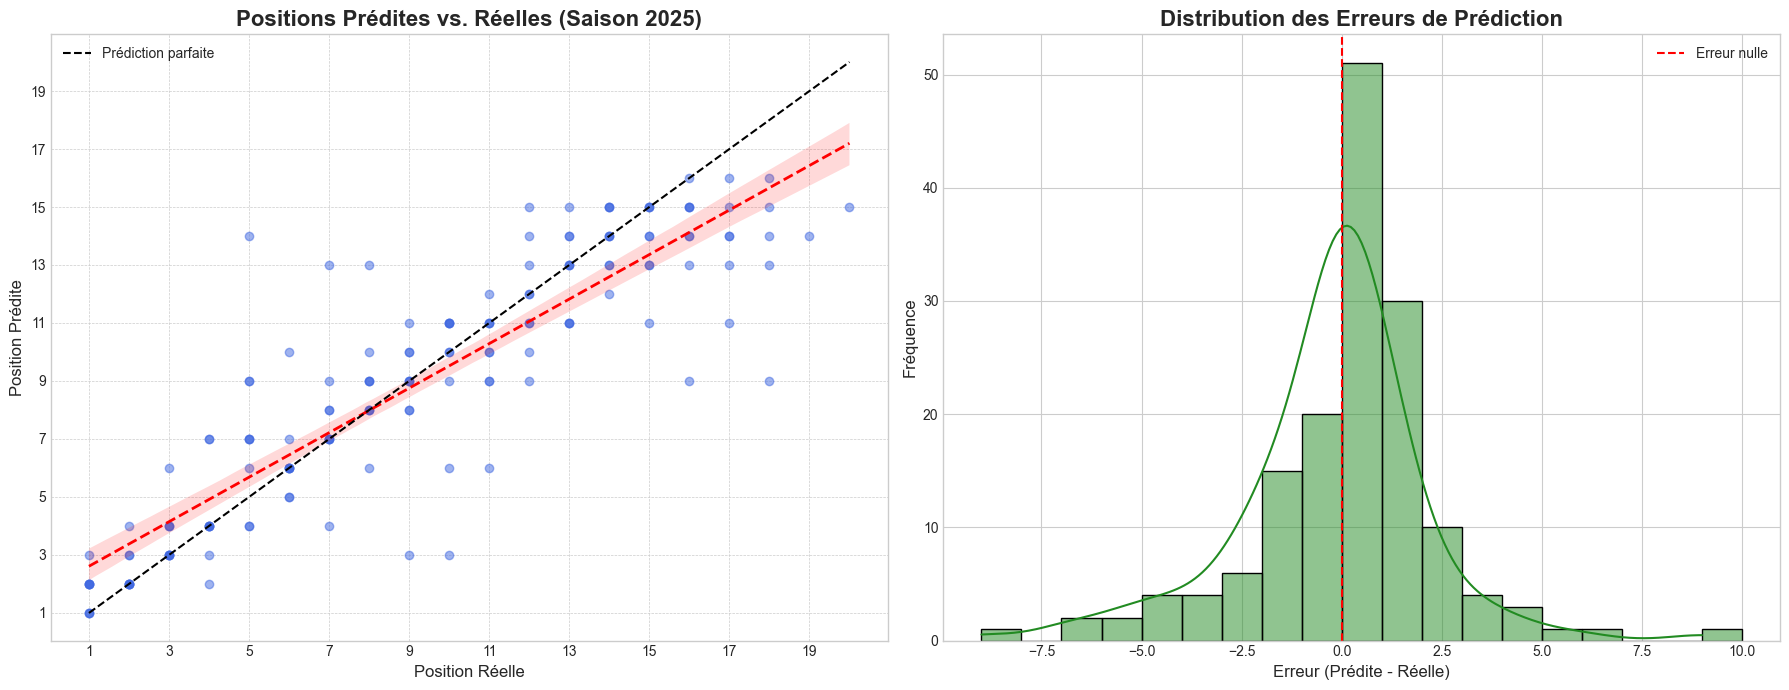

In [21]:
print("\n--- Visualisation des Résultats ---")

if 'results_df' in locals() and not results_df.empty:
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(1, 2, figsize=(18, 7))

    sns.regplot(x='position', y='predicted_position', data=results_df, ax=ax[0],
                scatter_kws={'alpha':0.5, 'color': 'royalblue'},
                line_kws={'color': 'red', 'linestyle': '--', 'linewidth': 2})
    ax[0].set_title('Positions Prédites vs. Réelles (Saison 2025)', fontsize=16, fontweight='bold')
    ax[0].set_xlabel('Position Réelle', fontsize=12)
    ax[0].set_ylabel('Position Prédite', fontsize=12)
    ax[0].plot([1, 20], [1, 20], 'k--', label='Prédiction parfaite')
    ax[0].legend()
    ax[0].set_xticks(range(1, 21, 2))
    ax[0].set_yticks(range(1, 21, 2))
    ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)

    results_df['error'] = results_df['predicted_position'] - results_df['position']
    sns.histplot(results_df['error'], bins=range(int(results_df['error'].min()), int(results_df['error'].max()) + 2), kde=True, ax=ax[1], color='forestgreen')
    ax[1].set_title('Distribution des Erreurs de Prédiction', fontsize=16, fontweight='bold')
    ax[1].set_xlabel('Erreur (Prédite - Réelle)', fontsize=12)
    ax[1].set_ylabel('Fréquence', fontsize=12)
    ax[1].axvline(0, color='red', linestyle='--', label='Erreur nulle')
    ax[1].legend()

    plt.tight_layout()
    plt.show()
else:
    print("Etape de visualisation sautée.")


--- Analyse par Course (MAE) ---


C:\Users\Altin\AppData\Local\Temp\ipykernel_17068\2568588235.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_by_race = results_df.groupby('race_name').apply(


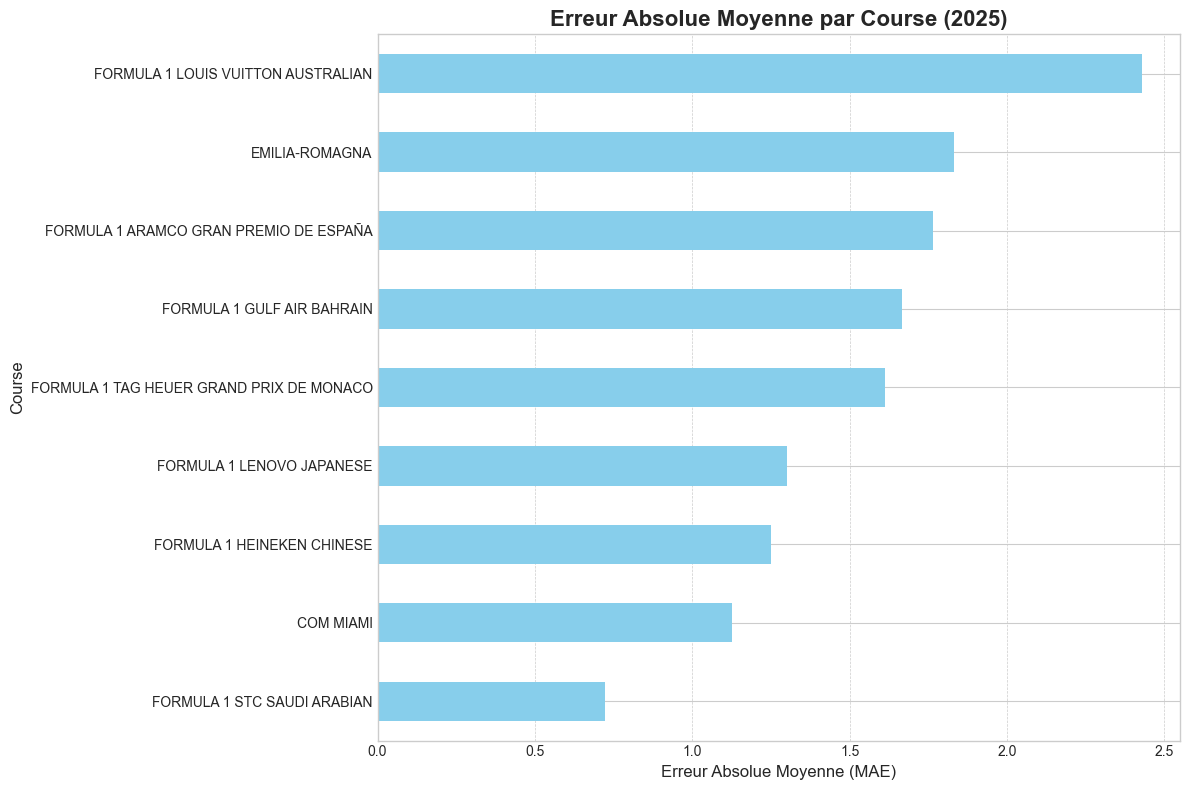

In [22]:
print("\n--- Analyse par Course (MAE) ---")

if 'results_df' in locals() and not results_df.empty:
    mae_by_race = results_df.groupby('race_name').apply(
        lambda x: mean_absolute_error(x['position'], x['predicted_position'])
    ).sort_values()

    plt.figure(figsize=(12, 8))
    mae_by_race.plot(kind='barh', color='skyblue')
    plt.title('Erreur Absolue Moyenne par Course (2025)', fontsize=16, fontweight='bold')
    plt.xlabel('Erreur Absolue Moyenne (MAE)', fontsize=12)
    plt.ylabel('Course', fontsize=12)
    plt.grid(axis='x', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("Etape d'analyse par course sautée.")